<a href="https://colab.research.google.com/github/SHIVANIVENNU/Basic-Sentiment-Analysis-and-Reporting/blob/main/Basic_sentiment_Analysis_and_Reporting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error: 'movie' column not found.


<ipython-input-1-5ec301efbfc4>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')


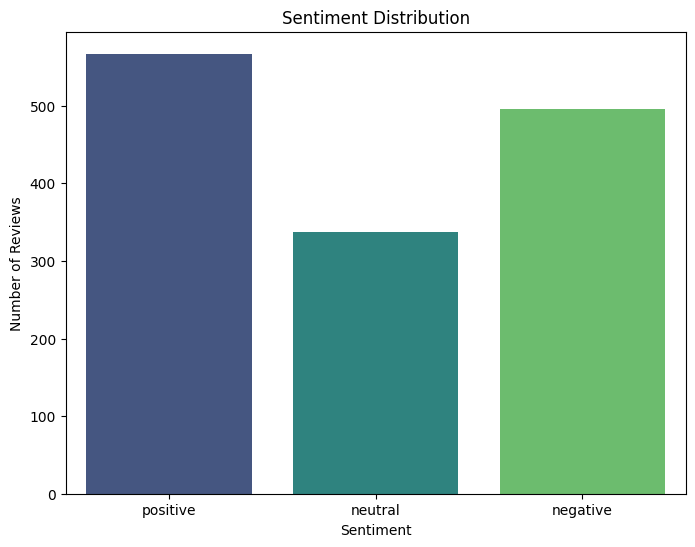

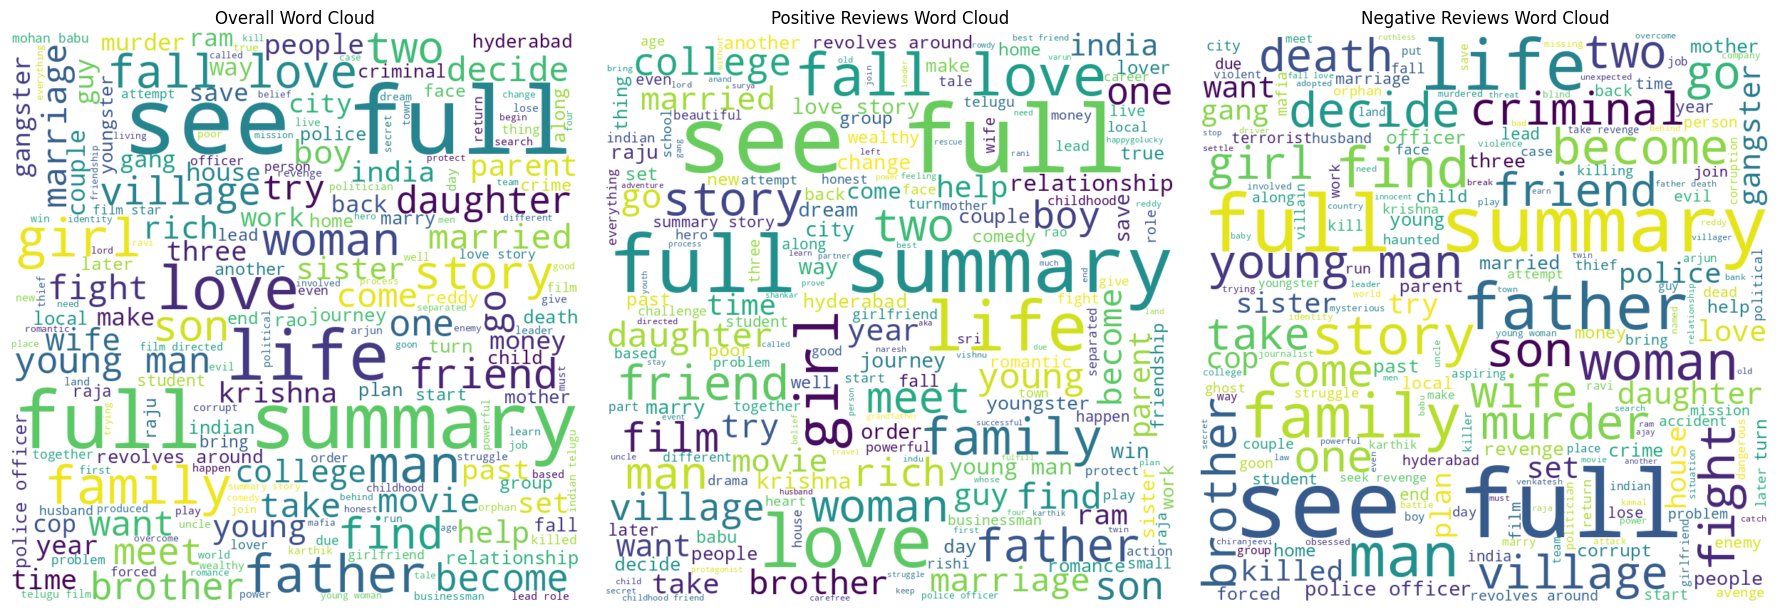

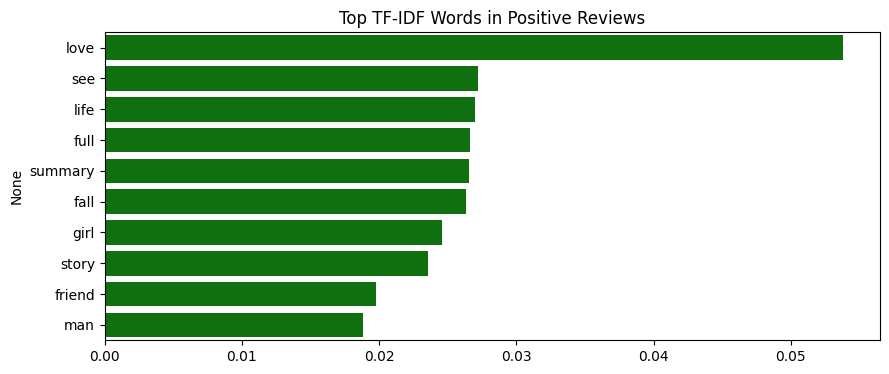

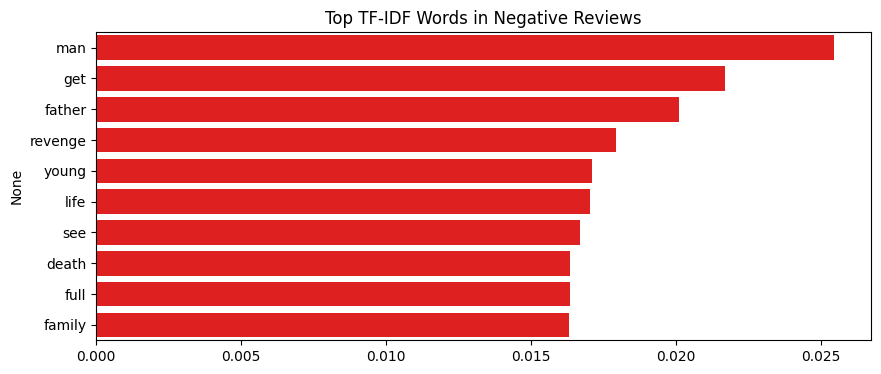

Movie with the most positive reviews: Devadasu (2 positive reviews)
Movie with the most negative reviews: Gang Leader (2 negative reviews)

Top 5 Movies with Most Positive Reviews:
Movie
Devadasu          2
Vijetha           2
iSmart Shankar    1
Joker             1
Jayam Manadera    1
Name: positive, dtype: int64

Top 5 Movies with Most Negative Reviews:
Movie
Veera               2
Gang Leader         2
1 - Nenokkadine     1
Idam Jagath         1
Iddarammayilatho    1
Name: negative, dtype: int64


<ipython-input-1-5ec301efbfc4>:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_positive['positive'].values, y=top5_positive.index, ax=axes[0], palette='viridis')
<ipython-input-1-5ec301efbfc4>:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5_negative['negative'].values, y=top5_negative.index, ax=axes[1], palette='magma')


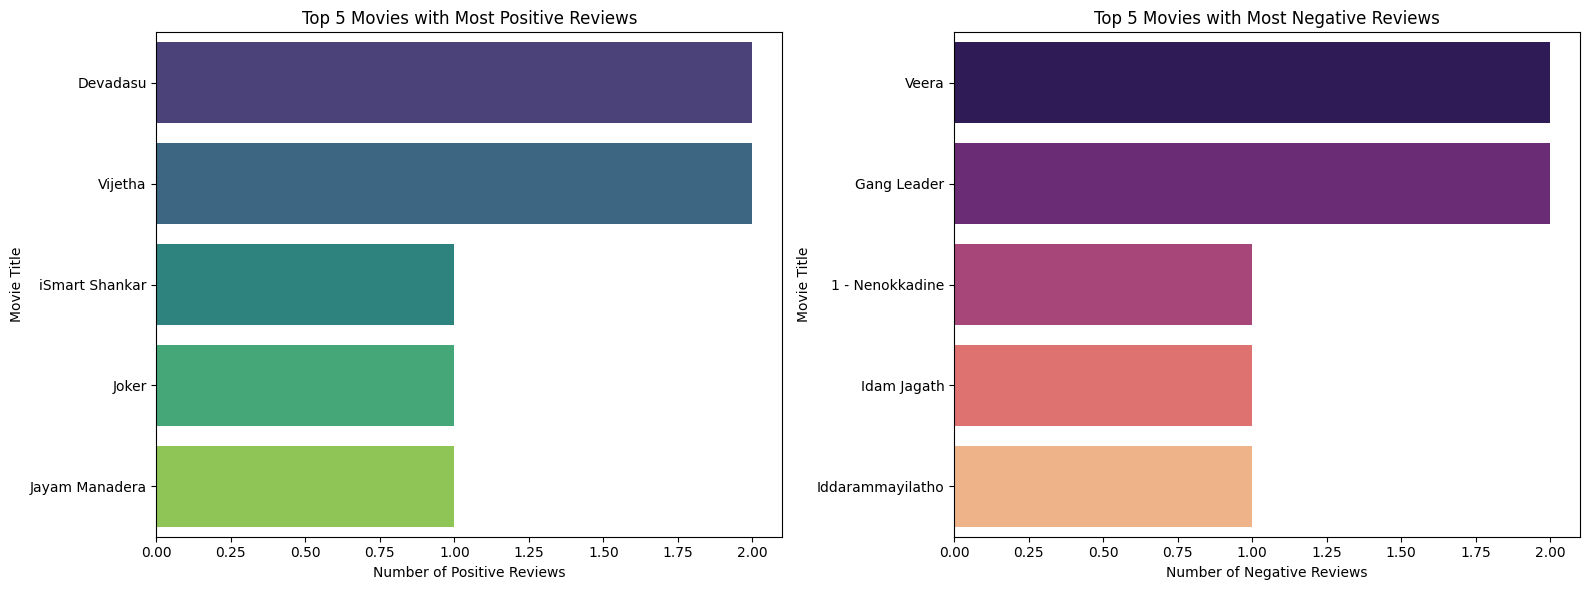

Preprocessing, sentiment analysis, and visualization completed.


In [ ]:
!pip install wordcloud
!pip install vaderSentiment
import pandas as pd
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download necessary NLTK data (only need to do this once)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True) # Download punkt_tab package to resolve the LookupError

def preprocess_text(text):
  if not isinstance(text,str):
      return ""
  text = text.lower()
  text = re.sub(r'[{}]'.format(re.escape(string.punctuation)),'',text)
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  return " ".join(tokens)

def get_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  score = analyzer.polarity_scores(text)['compound']
  if score >= 0.05:
        return 'positive'
  elif score <= -0.05:
        return 'negative'
  else:
        return 'neutral'
def plot_wordcloud(text_series, title,ax):
  text = " ".join(text_series.dropna())
  wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
  ax.imshow(wordcloud, interpolation='bilinear')
  ax.axis('off')
  ax.set_title(title)

# --- Main Script ---

# Load the dataset
try:
    df = pd.read_csv("TeluguMovies_dataset.csv") # Make sure this file exists and is accessible
except FileNotFoundError:
    print("Error: TeluguMovies_dataset.csv not found.")
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Data Cleaning and Preprocessing
#df = df.dropna()  # Remove rows with missing values # This line caused the NameError

# Instead of simply dropping rows with any missing values, we can impute the missing values with empty strings:
df['review'] = df['review'].fillna('')
df = df.dropna(subset=['review'])  # Drop if 'review' itself is missing

# Then add a check:
if df.empty:
    print("Error: DataFrame is empty after handling missing values.")
    exit()

if 'review' not in df.columns:
    print("Error: 'review' column not found.")
    exit()
if 'movie' not in df.columns:
    print("Error: 'movie' column not found.")
    exit()

df['cleaned_review'] = df['review'].apply(preprocess_text)

# Sentiment Analysis (on original text)
df['sentiment'] = df['review'].apply(get_sentiment)

# --- Visualization ---

# 1. Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# 2. Word Clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_wordcloud(df['cleaned_review'], "Overall Word Cloud", axes[0])
plot_wordcloud(df[df['sentiment'] == 'positive']['cleaned_review'], "Positive Reviews Word Cloud", axes[1])
plot_wordcloud(df[df['sentiment'] == 'negative']['cleaned_review'], "Negative Reviews Word Cloud", axes[2])
plt.tight_layout()
plt.show()

# 3. TF-IDF Analysis
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_review'])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

positive_tfidf = tfidf_df[df['sentiment'] == 'positive'].mean().sort_values(ascending=False).head(10)
negative_tfidf = tfidf_df[df['sentiment'] == 'negative'].mean().sort_values(ascending=False).head(10)

if not positive_tfidf.empty:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=positive_tfidf.values, y=positive_tfidf.index, color="green")
    plt.title("Top TF-IDF Words in Positive Reviews")
    plt.show()
else:
    print("No positive reviews found to calculate TF-IDF.")

if not negative_tfidf.empty:
    plt.figure(figsize=(10, 4))
    sns.barplot(x=negative_tfidf.values, y=negative_tfidf.index, color="red")
    plt.title("Top TF-IDF Words in Negative Reviews")
    plt.show()
else:
    print("No negative reviews found to calculate TF-IDF.")
# --- Movies with Most Positive/Negative Reviews ---
# Group by movie title and count the occurrences of each sentiment
sentiment_by_movie = df.groupby('Movie')['sentiment'].value_counts().unstack(fill_value=0)

# Get the movie with the most positive reviews
most_positive_movie = sentiment_by_movie['positive'].idxmax()
most_positive_count = sentiment_by_movie['positive'].max()

# Get the movie with the most negative reviews
most_negative_movie = sentiment_by_movie['negative'].idxmax()
most_negative_count = sentiment_by_movie['negative'].max()

print(f"Movie with the most positive reviews: {most_positive_movie} ({most_positive_count} positive reviews)")
print(f"Movie with the most negative reviews: {most_negative_movie} ({most_negative_count} negative reviews)")

# --- Top 5 movies for positive and negative ---
top5_positive = sentiment_by_movie.sort_values(by='positive', ascending=False).head(5)
top5_negative = sentiment_by_movie.sort_values(by='negative', ascending=False).head(5)

print("\nTop 5 Movies with Most Positive Reviews:")
print(top5_positive['positive'])  # Show positive review counts

print("\nTop 5 Movies with Most Negative Reviews:")
print(top5_negative['negative'])  # Show negative review counts

# --- Visualization of Top 5 ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=top5_positive['positive'].values, y=top5_positive.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 5 Movies with Most Positive Reviews')
axes[0].set_xlabel('Number of Positive Reviews')
axes[0].set_ylabel('Movie Title')

sns.barplot(x=top5_negative['negative'].values, y=top5_negative.index, ax=axes[1], palette='magma')
axes[1].set_title('Top 5 Movies with Most Negative Reviews')
axes[1].set_xlabel('Number of Negative Reviews')
axes[1].set_ylabel('Movie Title')

plt.tight_layout()
plt.show()

# --- Save Processed Data ---
df.to_csv("TeluguMovies_Processed.csv", index=False) # change the name if necessary.
print("Preprocessing, sentiment analysis, and visualization completed.")